<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/may---3rd-week/datacrunch_neural_network_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import math
import random
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
import pathlib
from sklearn import model_selection, metrics, decomposition, preprocessing
import requests
from tqdm.auto import tqdm
from scipy import stats

# tensorflow keras
import tensorflow as tf

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Load data

The data are fairly simple tabular data: just X_train, y_train, and X_test.

In [2]:
data_path = '../input/datacrunch-tournament/'

def load_data():
    """
    load tournament data
    """
    train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
    train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
    hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

    X_train = pd.read_csv(train_datalink_X)
    y_train = pd.read_csv(train_datalink_y)
    X_test = pd.read_csv(hackathon_data_link)


    # lower case columns
    X_train.columns = X_train.columns.str.lower()
    y_train.columns = y_train.columns.str.lower()
    X_test.columns = X_test.columns.str.lower()
    
    return X_train, y_train, X_test

X_train, y_train, X_test = load_data()

In [3]:
print(X_train.shape)
X_train.head()

(6524, 22)


,moons,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_19,feature_20,feature_21
0,0,0xd11efd10c7cc3099,0.50,0.0,0.00,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.50,0.25,0.50,0.50,0.75,0.75,0.75,0.75
1,0,0x638cf8491e2531e1,0.50,0.0,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,0x79acc91873477033,0.75,0.5,0.25,1.0,0.75,0.0,0.0,0.0,0.0,0.5,0.5,1.00,0.75,0.50,0.25,0.75,0.25,0.50,1.00,0.75
3,0,0x1c460564096ec677,0.50,0.0,0.00,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.75,0.50,0.75,0.75,0.50,0.50,0.75,0.50
4,0,0x4ee26947ed8f9add,0.75,0.0,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [4]:
print(y_train.shape)
y_train.head()

(6524, 3)


,target_r,target_g,target_b
0,0.25,0.25,0.25
1,0.00,0.00,0.00
2,0.50,0.50,0.50
3,0.00,0.00,0.00
4,0.75,1.00,0.75


So 3 targets???

In [5]:
print(X_test.shape)
X_test.head()

(4423, 22)


,moons,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_19,feature_20,feature_21
0,0,0x36d40e9e470a255b,0.25,0.0,0.75,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0
1,0,0xa6c084a9c345e4ca,0.25,0.5,0.25,0.75,1.0,0.0,0.0,0.0,0.0,0.25,0.25,0.75,1.0,0.50,0.25,0.25,0.5,0.75,0.75,1.0
2,0,0xfb1d7dd87c2dd061,0.00,0.5,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.75,0.75,0.75,1.0,0.25,0.25,0.25,0.5,0.50,0.75,1.0
3,0,0x10173cf2a8d24442,0.25,0.0,0.75,0.75,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0
4,0,0x28aae12a4ab1747,0.25,1.0,0.25,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.75,0.0,0.25,0.00,0.50,0.0,0.00,0.50,0.0


# EDA
Let's perform a simple exploratory data analysis.

Apparently there are 'feature' columns, and they all look quantiles.

In [6]:
features = X_train.columns[X_train.columns.str.startswith('feature')].values.tolist()
print('{} features: {}'.format(len(features), features))

20 features: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_19', 'feature_20', 'feature_21']


In [7]:
X_train[features[9]].value_counts()

1.00    1305
0.75    1305
0.25    1305
0.00    1305
0.50    1304
Name: feature_10, dtype: int64

Also, there is a column called "Moons".

In [8]:
group = 'moons'

In [9]:
X_train[group].value_counts()

13    477
12    477
11    476
10    474
9     472
8     471
7     469
6     468
5     464
4     462
3     459
2     455
1     453
0     447
Name: moons, dtype: int64

In [10]:
X_test[group].value_counts()

5    496
6    495
4    495
7    494
8    493
3    492
2    488
1    487
0    483
Name: moons, dtype: int64

"Moons" in train and test do not overlaps, suggesting that they are an arbitorary unit of the timing of data collection.

As for our targets, they also look quantiles.

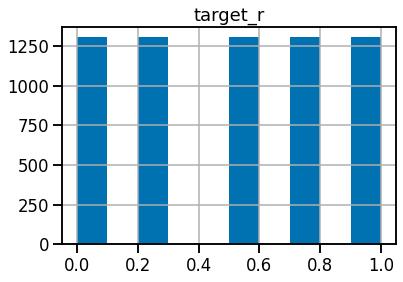

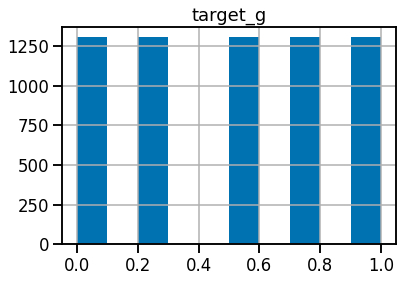

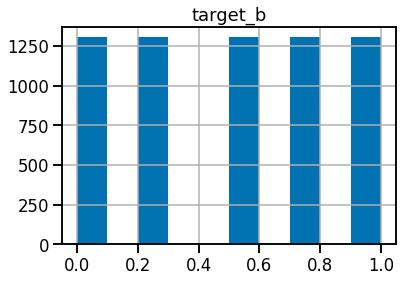

In [11]:
for t in y_train.columns.values.tolist():
    y_train[t].hist()
    plt.title(t)
    plt.show()

# Feature Engineering
Let's perform a simple feature engineering!

Here we add

- basic statistics features
- polynomial features
- PCA features

In [12]:
def fe(df, features):
    """
    add basic statistics
    """
    df['features_mean'] = df[features].mean(axis=1)
    df['features_std'] = df[features].std(axis=1)
    df['features_max'] = df[features].max(axis=1)
    df['features_min'] = df[features].min(axis=1)
    df['features_mad'] = df[features].mad(axis=1)
    df['features_skew'] = df[features].skew(axis=1)
    df['features_kurt'] = df[features].kurt(axis=1)
    return df

X_train = fe(X_train, features)
X_test = fe(X_test, features)

In [13]:
def add_poly(df, features, deg=2):
    """
    add polynomial features
    """
    poly = preprocessing.PolynomialFeatures(deg)
    emb = poly.fit_transform(df[features].values)
    for i in range(len(features), emb.shape[1]):
        df[f'poly_{i+1}'] = emb[:, i]
    return df

X_train = add_poly(X_train, features, deg=2)
X_test = add_poly(X_test, features, deg=2)

In [14]:
def add_pca(df, features, n_components=5):    
    """
    add PCA features
    """
    trans = decomposition.IncrementalPCA(n_components)
    emb = trans.fit_transform(df[features].values)
    for i in range(emb.shape[1]):
        df[f'pca_{i+1}'] = emb[:, i]
    return df

df = pd.concat([X_train, X_test], ignore_index=False)
df = add_pca(df, features, n_components=5)
X_train = df.iloc[:len(X_train)]
X_test = df.iloc[len(X_train):]

del df

In [15]:
# show all features
features = X_train.columns[X_train.columns.str.startswith('feature')].values.tolist()
features += X_train.columns[X_train.columns.str.startswith('poly')].values.tolist()
features += X_train.columns[X_train.columns.str.startswith('pca')].values.tolist()

print('{} features: {}'.format(len(features), features))

243 features: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_19', 'feature_20', 'feature_21', 'features_mean', 'features_std', 'features_max', 'features_min', 'features_mad', 'features_skew', 'features_kurt', 'poly_21', 'poly_22', 'poly_23', 'poly_24', 'poly_25', 'poly_26', 'poly_27', 'poly_28', 'poly_29', 'poly_30', 'poly_31', 'poly_32', 'poly_33', 'poly_34', 'poly_35', 'poly_36', 'poly_37', 'poly_38', 'poly_39', 'poly_40', 'poly_41', 'poly_42', 'poly_43', 'poly_44', 'poly_45', 'poly_46', 'poly_47', 'poly_48', 'poly_49', 'poly_50', 'poly_51', 'poly_52', 'poly_53', 'poly_54', 'poly_55', 'poly_56', 'poly_57', 'poly_58', 'poly_59', 'poly_60', 'poly_61', 'poly_62', 'poly_63', 'poly_64', 'poly_65', 'poly_66', 'poly_67', 'poly_68', 'poly_69', 'poly_70', 'poly_71', 'poly_72', 'poly_73', 'poly_74', 'poly

So in this way we can expand our features dramatically!

# Scaling
We perform the MinMax scaling and gaussian power transformation.

Also we perform power transformation to approximate gaussian distribution in each feature.

In [16]:
# combine
df = pd.concat([X_train, X_test], ignore_index=False)

# power transform
pt = preprocessing.QuantileTransformer(n_quantiles=100, random_state=42, output_distribution="normal")
df[features] = pt.fit_transform(df[features].values)

# minmax
scaler = preprocessing.MinMaxScaler()
df[features] = scaler.fit_transform(df[features].values)

# split again
X_train = df.iloc[:len(X_train)]
X_test = df.iloc[len(X_train):]

del df

# Design a Neural Network
Since we have 3 targets in each row, we use a simple neural network to predict all at once.

In [17]:
# set seed for reproducibity
def seed_everything(seed : int):    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [18]:
# NN hyperparams
params = {
    'input_dropout': 0.1,
    'hidden_layers': 3,
    'hidden_units': 256,
    'hidden_activation': 'relu',
    'dropout': 0.2,
    'decay_factor': 1.5,
    'lr': 1e-3,
    'batch_size': 4096,
    'epochs': 1000
}
    
def nn_model(params, features):
    """
    NN hyperparameters and models
    
    :INPUT: 
    
    :L: the number of features (int)
    """

    # NN model architecture
    n_neuron = params['hidden_units']

    inputs = tf.keras.layers.Input(shape=(len(features), ))
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dropout(params['input_dropout'])(x)
    
    x = tf.keras.layers.Dense(n_neuron, activation=params['hidden_activation'])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(params['dropout'])(x)

    # stack more layers
    for i in np.arange(params['hidden_layers'] - 1):
        x = tf.keras.layers.Dense(n_neuron // (params['decay_factor'] * (i+1)), 
                         activation=params['hidden_activation'])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(params['dropout'])(x)
        
    # output
    out1 = tf.keras.layers.Dense(1, activation='linear', name='out1')(x)
    out2 = tf.keras.layers.Dense(1, activation='linear', name='out2')(x)
    out3 = tf.keras.layers.Dense(1, activation='linear', name='out3')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=[out1, out2, out3])

    # compile
    loss = [
        'mse',  
        'mse',  
        'mse',  
        ]
    loss_weights = [1, 1, 1]
    opt = tf.keras.optimizers.Adam(lr=params['lr'])
    model.compile(loss=loss, loss_weights=loss_weights, optimizer=opt)
    
    return model

model = nn_model(params, features)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 243)]        0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 243)          972         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 243)          0           batch_normalization[0][0]        
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          62464       dropout[0][0]                    
______________________________________________________________________________________________

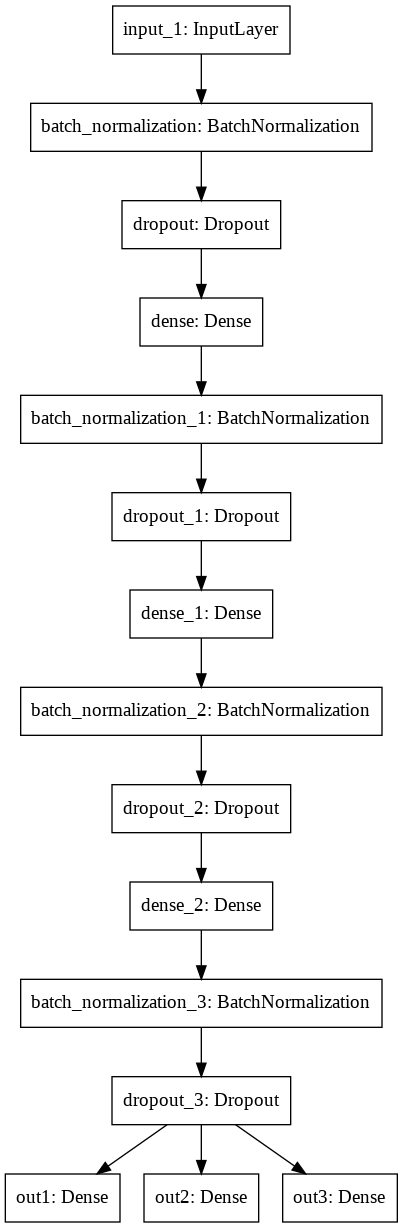

In [19]:
tf.keras.utils.plot_model(model)

# Fit
We use a simple GroupKFold with "Moons" as the group for now.

In [20]:
# spearman correlation as a score 
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred)*100)[0]
    print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))

In [21]:
oof = pd.DataFrame()
oof['id'] = X_train['id'].values
prediction = pd.DataFrame()
prediction['id'] = X_test['id'].values
for t in ['target_r', 'target_g', 'target_b']:
    oof[t] = 0
    prediction[t] = 0
    
NFOLD = 7
kf = model_selection.GroupKFold(n_splits=NFOLD)
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train, X_train[group]))):
    # split
    print('----------------------------')
    print(f'Fold {fold}...')
    print('----------------------------')
    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # define callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, mode='min')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'nn_weight{fold}.hdf5', save_weights_only=True, verbose=0, monitor='val_loss', save_best_only=True)
    
    # format dataset
    train_set = {'X': X_tr[features].values, 'y': y_tr.values}
    valid_set = {'X': X_va[features].values, 'y': y_va.values}
    
    # fit
    tf.keras.backend.clear_session()
    model = nn_model(params, features)
    history = model.fit(
        train_set['X'], train_set['y'], 
        callbacks=[early_stop, lr_scheduler, model_checkpoint_callback], 
        verbose=2, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(valid_set['X'], valid_set['y'])
    ) 
    
    # predict
    oof_pred = model.predict(valid_set['X'])
    pred = model.predict(X_test[features].values)    
    for i, t in enumerate(['target_r', 'target_g', 'target_b']):
        # validation
        oof[t].iloc[test_index] = oof_pred[i].ravel()
        print(f'FOLD {fold}: Target={t}')
        scorer(valid_set['y'][:, i], oof_pred[i].ravel())
        
        # test
        prediction[t] += pred[i].ravel() / NFOLD

----------------------------
Fold 0...
----------------------------
Epoch 1/1000
2/2 - 3s - loss: 8.8034 - out1_loss: 3.2277 - out2_loss: 2.8655 - out3_loss: 2.7101 - val_loss: 0.9752 - val_out1_loss: 0.1624 - val_out2_loss: 0.5130 - val_out3_loss: 0.2997
Epoch 2/1000
2/2 - 0s - loss: 6.6497 - out1_loss: 2.4045 - out2_loss: 2.0461 - out3_loss: 2.1991 - val_loss: 1.0125 - val_out1_loss: 0.2633 - val_out2_loss: 0.4469 - val_out3_loss: 0.3023
Epoch 3/1000
2/2 - 0s - loss: 5.5587 - out1_loss: 1.9826 - out2_loss: 1.7354 - out3_loss: 1.8407 - val_loss: 1.0695 - val_out1_loss: 0.3093 - val_out2_loss: 0.4219 - val_out3_loss: 0.3383
Epoch 4/1000
2/2 - 0s - loss: 4.8299 - out1_loss: 1.7319 - out2_loss: 1.4691 - out3_loss: 1.6289 - val_loss: 0.9948 - val_out1_loss: 0.2371 - val_out2_loss: 0.4087 - val_out3_loss: 0.3489
Epoch 5/1000
2/2 - 0s - loss: 4.3522 - out1_loss: 1.4647 - out2_loss: 1.3676 - out3_loss: 1.5199 - val_loss: 0.9065 - val_out1_loss: 0.1741 - val_out2_loss: 0.4078 - val_out3_loss:

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


FOLD 0: Target=target_r
Score as calculated for the leader board (っಠ‿ಠ)っ 0.09055328881162118
FOLD 0: Target=target_g
Score as calculated for the leader board (っಠ‿ಠ)っ 0.159033209747801
FOLD 0: Target=target_b
Score as calculated for the leader board (っಠ‿ಠ)っ 0.12997481740396907
----------------------------
Fold 1...
----------------------------
Epoch 1/1000
2/2 - 2s - loss: 8.8200 - out1_loss: 2.9001 - out2_loss: 2.5659 - out3_loss: 3.3540 - val_loss: 0.9541 - val_out1_loss: 0.1651 - val_out2_loss: 0.2754 - val_out3_loss: 0.5135
Epoch 2/1000
2/2 - 0s - loss: 6.6906 - out1_loss: 2.2601 - out2_loss: 2.0163 - out3_loss: 2.4142 - val_loss: 0.9489 - val_out1_loss: 0.2405 - val_out2_loss: 0.2403 - val_out3_loss: 0.4681
Epoch 3/1000
2/2 - 0s - loss: 5.5781 - out1_loss: 1.8941 - out2_loss: 1.7249 - out3_loss: 1.9590 - val_loss: 0.9631 - val_out1_loss: 0.3213 - val_out2_loss: 0.2175 - val_out3_loss: 0.4242
Epoch 4/1000
2/2 - 0s - loss: 4.6138 - out1_loss: 1.5561 - out2_loss: 1.4673 - out3_loss: 1

# CV
Let's see the overall cross-validation score!

In [22]:
for i, t in enumerate(['target_r', 'target_g', 'target_b']):
    # validation
    scorer(y_train[t].values, oof[t].values)

Score as calculated for the leader board (っಠ‿ಠ)っ 0.020761871867394005
Score as calculated for the leader board (っಠ‿ಠ)っ 0.044951293355216096
Score as calculated for the leader board (っಠ‿ಠ)っ 0.06178224766217438


Not bad?

# Submit
Let's submit using your own API key. Alternatively you can submit the prediction.csv manually.

In [23]:
# save
prediction[['target_r', 'target_g', 'target_b']].to_csv('prediction.csv', index=False)
print('prediction saved!')

prediction saved!


In [24]:
prediction

,id,target_r,target_g,target_b
0,0x36d40e9e470a255b,0.402710,0.391499,0.420158
1,0xa6c084a9c345e4ca,0.505873,0.462898,0.484594
2,0xfb1d7dd87c2dd061,0.498212,0.487000,0.508493
3,0x10173cf2a8d24442,0.415130,0.364609,0.401572
4,0x28aae12a4ab1747,0.481101,0.420820,0.437665
...,...,...,...,...
4418,0x527c75c9b79ee591,0.419169,0.457077,0.410938
4419,0x632ef75dc42aeb2f,0.431554,0.454914,0.393767
4420,0x3648493e959543db,0.493491,0.480952,0.423846
4421,0xbfdf59b107d8dc5e,0.429103,0.434532,0.405900


In [26]:
# prediction[prediction['target_g'] > 1]
for i in prediction.columns:
    print(prediction[i].nunique())

4423
4326
4327
4328


In [27]:
prediction.target_r.value_counts().head(20)

0.416217    23
0.462630     9
0.441785     5
0.393883     4
0.452643     4
0.419588     4
0.420622     4
0.415130     4
0.490698     4
0.513428     3
0.467220     3
0.431604     3
0.418041     3
0.460768     3
0.406583     3
0.424886     3
0.511916     3
0.494555     2
0.415456     2
0.388166     2
Name: target_r, dtype: int64

In [28]:
prediction.describe()

,target_r,target_g,target_b
count,4423.000000,4423.000000,4423.000000
mean,0.457630,0.443140,0.448925
std,0.038885,0.039568,0.039230
min,0.321073,0.313699,0.312642
25%,0.430164,0.415640,0.423610
50%,0.459622,0.444554,0.449994
75%,0.484492,0.470937,0.475745
max,0.592575,0.587986,0.579442


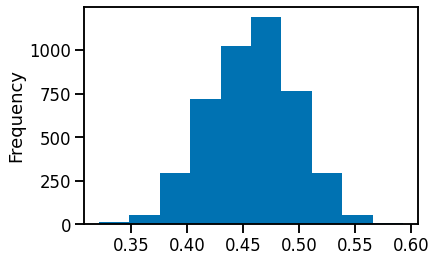

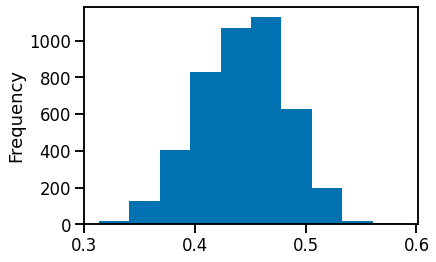

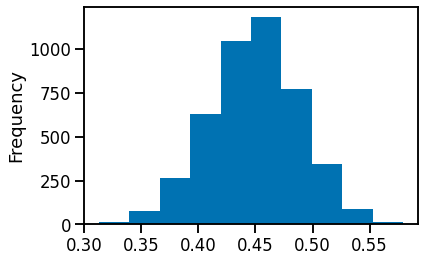

In [29]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [25]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)


All done!